In [42]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras import layers
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from pandas import concat
from pandas import read_csv
from helper import series_to_supervised, stage_series_to_supervised
import keras_tuner as kt

In [43]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [44]:
dataset = pd.read_csv('../../data/pollution.csv', index_col=0)
dataset.fillna(0, inplace=True)
data = dataset
data

,pollution,dew,temp,press,wnd_spd,snow,rain,NE,NW,SE,cv
date,,,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,0,0,1,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,0,0,1,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,0,0,1,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,0,0,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,231.97,0,0,0,1,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,237.78,0,0,0,1,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,242.70,0,0,0,1,0,0


In [45]:
print(dataset.columns)

Index(['pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain', 'NE',
       'NW', 'SE', 'cv'],
      dtype='object')


In [46]:
# specify the number of lag hours
n_hours = 24*3
K = 12

### Target time series (4)
- 'WS_S1',  'TWS_S25A', 'TWS_S25B', 'TWS_S26',    
        
               
### Prior known covariates (9)
- 'WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B',  'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN'


### Prior unknown covariates (6)
- 'FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26'

#### Target time series: water stage (4)

In [47]:
# Pre-processing
stages = dataset[['pollution']]
print("stages.shape:", stages.shape)


stages_supervised = series_to_supervised(stages, n_hours, K)
print("stages_supervised.shape:", stages_supervised.shape)

stages.shape: (43800, 1)
stages_supervised.shape: (43717, 84)


In [48]:
stages_supervised

,var1(t-72),var1(t-71),var1(t-70),var1(t-69),var1(t-68),var1(t-67),var1(t-66),var1(t-65),var1(t-64),var1(t-63),...,var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6),var1(t+7),var1(t+8),var1(t+9),var1(t+10),var1(t+11)
date,,,,,,,,,,,,,,,,,,,,,
2010-01-05 00:00:00,129.0,148.0,159.0,181.0,138.0,109.0,105.0,124.0,120.0,132.0,...,27.0,25.0,28.0,28.0,27.0,27.0,27.0,29.0,36.0,30.0
2010-01-05 01:00:00,148.0,159.0,181.0,138.0,109.0,105.0,124.0,120.0,132.0,140.0,...,25.0,28.0,28.0,27.0,27.0,27.0,29.0,36.0,30.0,27.0
2010-01-05 02:00:00,159.0,181.0,138.0,109.0,105.0,124.0,120.0,132.0,140.0,152.0,...,28.0,28.0,27.0,27.0,27.0,29.0,36.0,30.0,27.0,39.0
2010-01-05 03:00:00,181.0,138.0,109.0,105.0,124.0,120.0,132.0,140.0,152.0,148.0,...,28.0,27.0,27.0,27.0,29.0,36.0,30.0,27.0,39.0,41.0
2010-01-05 04:00:00,138.0,109.0,105.0,124.0,120.0,132.0,140.0,152.0,148.0,164.0,...,27.0,27.0,27.0,29.0,36.0,30.0,27.0,39.0,41.0,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 08:00:00,160.0,160.0,92.0,59.0,69.0,48.0,32.0,33.0,45.0,42.0,...,7.0,12.0,17.0,11.0,9.0,11.0,8.0,9.0,10.0,8.0
2014-12-31 09:00:00,160.0,92.0,59.0,69.0,48.0,32.0,33.0,45.0,42.0,41.0,...,12.0,17.0,11.0,9.0,11.0,8.0,9.0,10.0,8.0,10.0
2014-12-31 10:00:00,92.0,59.0,69.0,48.0,32.0,33.0,45.0,42.0,41.0,110.0,...,17.0,11.0,9.0,11.0,8.0,9.0,10.0,8.0,10.0,10.0


#### Prior unknown covariates (6)

In [49]:
# prior_unknown = dataset[['FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26' ]]
# print("prior_unknown.shape:", prior_unknown.shape)

# prior_unknown_supervised = series_to_supervised(prior_unknown, n_hours, K)
# print("prior_unknown_supervised.shape:", prior_unknown_supervised.shape)

In [50]:
# prior_unknown_supervised

#### Prior known covariates (9)

In [51]:
prior_known = dataset[['dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain', 'NE', 'NW', 'SE', 'cv']]
print("prior_known.shape:", prior_known.shape)

prior_known_supervised = series_to_supervised(prior_known, n_hours, K)
print("prior_known_supervised.shape:", prior_known_supervised.shape)

prior_known.shape: (43800, 10)
prior_known_supervised.shape: (43717, 840)


In [52]:
# prior_known_supervised

### N_out, N_in, K

In [53]:
past_cov = dataset[['dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain', 'NE', 'NW', 'SE', 'cv']]

past_cov_supervised = series_to_supervised(past_cov, n_hours, K)
print("past_cov_supervised.shape:", past_cov_supervised.shape)

past_cov_supervised.shape: (43717, 840)


In [54]:
# past_cov_supervised  # 6 + 9 = 15 features

In [55]:
past_ws_supervised = stages_supervised.iloc[:, :n_hours*stages.shape[1]]
past_ws_supervised.reset_index(drop=True, inplace=True)
past_ws_supervised.columns = ['past_ws_supervised_' + i for i in list(past_ws_supervised.columns)]

In [56]:
# past_ws_supervised  # 4

In [57]:
columns = []
for i in range(n_hours):
    columns = columns + past_cov_supervised.columns[i*past_cov.shape[1]:(i+1)*past_cov.shape[1]].tolist()
    columns = columns + past_ws_supervised.columns[i*stages.shape[1]:(i+1)*stages.shape[1]].tolist()
# columns

In [58]:
past_cov_supervised.reset_index(drop=True, inplace=True)
past_ws_supervised.reset_index(drop=True, inplace=True)

past_cov_ws_supervised = pd.concat([past_cov_supervised, past_ws_supervised], axis=1)
past_cov_ws_supervised = past_cov_ws_supervised[columns]


In [59]:
# past_cov_ws_supervised

In [60]:
shift_prior_known_supervised = prior_known_supervised.iloc[:, K*prior_known.shape[1]:]  # shift 2 days for prior known covariates
shift_prior_known_supervised.reset_index(drop=True, inplace=True)
shift_prior_known_supervised.columns = ['shift_prior_known_supervised_' + i for i in list(shift_prior_known_supervised.columns)]
shift_prior_known_supervised

,shift_prior_known_supervised_var1(t-60),shift_prior_known_supervised_var2(t-60),shift_prior_known_supervised_var3(t-60),shift_prior_known_supervised_var4(t-60),shift_prior_known_supervised_var5(t-60),shift_prior_known_supervised_var6(t-60),shift_prior_known_supervised_var7(t-60),shift_prior_known_supervised_var8(t-60),shift_prior_known_supervised_var9(t-60),shift_prior_known_supervised_var10(t-60),...,shift_prior_known_supervised_var1(t+11),shift_prior_known_supervised_var2(t+11),shift_prior_known_supervised_var3(t+11),shift_prior_known_supervised_var4(t+11),shift_prior_known_supervised_var5(t+11),shift_prior_known_supervised_var6(t+11),shift_prior_known_supervised_var7(t+11),shift_prior_known_supervised_var8(t+11),shift_prior_known_supervised_var9(t+11),shift_prior_known_supervised_var10(t+11)
0,-8.0,-5.0,1026.0,23.69,0.0,0.0,0.0,0.0,1.0,0.0,...,-25.0,-13.0,1035.0,34.43,0.0,0.0,1.0,0.0,0.0,0.0
1,-8.0,-5.0,1025.0,27.71,0.0,0.0,0.0,0.0,1.0,0.0,...,-25.0,-12.0,1034.0,39.35,0.0,0.0,1.0,0.0,0.0,0.0
2,-9.0,-5.0,1025.0,31.73,0.0,0.0,0.0,0.0,1.0,0.0,...,-24.0,-11.0,1032.0,41.14,0.0,0.0,1.0,0.0,0.0,0.0
3,-9.0,-5.0,1025.0,35.75,0.0,0.0,0.0,0.0,1.0,0.0,...,-22.0,-11.0,1032.0,0.89,0.0,0.0,0.0,0.0,0.0,1.0
4,-9.0,-5.0,1026.0,37.54,0.0,0.0,0.0,0.0,1.0,0.0,...,-23.0,-11.0,1031.0,1.79,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43712,-13.0,3.0,1017.0,0.89,0.0,0.0,0.0,0.0,0.0,1.0,...,-23.0,-2.0,1034.0,231.97,0.0,0.0,0.0,1.0,0.0,0.0
43713,-13.0,1.0,1017.0,1.78,0.0,0.0,0.0,0.0,0.0,1.0,...,-22.0,-3.0,1034.0,237.78,0.0,0.0,0.0,1.0,0.0,0.0
43714,-10.0,2.0,1017.0,2.67,0.0,0.0,0.0,0.0,0.0,1.0,...,-22.0,-3.0,1034.0,242.70,0.0,0.0,0.0,1.0,0.0,0.0
43715,-10.0,-2.0,1017.0,3.12,0.0,0.0,0.0,0.0,0.0,1.0,...,-22.0,-4.0,1034.0,246.72,0.0,0.0,0.0,1.0,0.0,0.0


In [61]:
shift_prior_known_past_cov_ws_supervised = pd.concat([past_cov_ws_supervised, shift_prior_known_supervised], axis=1)


In [62]:
# shift_prior_known_past_cov_ws_supervised

In [63]:
future_ws_supervised = stages_supervised.iloc[:, n_hours*stages.shape[1]:]
future_ws_supervised.reset_index(drop=True, inplace=True)
future_ws_supervised

,var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6),var1(t+7),var1(t+8),var1(t+9),var1(t+10),var1(t+11)
0,30.0,34.0,27.0,25.0,28.0,28.0,27.0,27.0,27.0,29.0,36.0,30.0
1,34.0,27.0,25.0,28.0,28.0,27.0,27.0,27.0,29.0,36.0,30.0,27.0
2,27.0,25.0,28.0,28.0,27.0,27.0,27.0,29.0,36.0,30.0,27.0,39.0
3,25.0,28.0,28.0,27.0,27.0,27.0,29.0,36.0,30.0,27.0,39.0,41.0
4,28.0,28.0,27.0,27.0,27.0,29.0,36.0,30.0,27.0,39.0,41.0,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...
43712,8.0,8.0,7.0,12.0,17.0,11.0,9.0,11.0,8.0,9.0,10.0,8.0
43713,8.0,7.0,12.0,17.0,11.0,9.0,11.0,8.0,9.0,10.0,8.0,10.0
43714,7.0,12.0,17.0,11.0,9.0,11.0,8.0,9.0,10.0,8.0,10.0,10.0
43715,12.0,17.0,11.0,9.0,11.0,8.0,9.0,10.0,8.0,10.0,10.0,8.0


### Concatenation

In [64]:
all_data = concat([shift_prior_known_past_cov_ws_supervised, future_ws_supervised], axis=1)
# print("all_data", all_data)
print("all_data.shape:", all_data.shape)

all_data.shape: (43717, 1524)


### Train & Test set

In [65]:
all_data = all_data.values
n_train_hours = int(len(all_data)*0.8)
print("n_train_hours:", n_train_hours)


train = all_data[:n_train_hours, :]
test = all_data[n_train_hours:, :]

n_train_hours: 34973


In [66]:
n_obs = n_hours * (prior_known.shape[1]+data.shape[1])
n_obs

1512

### Normalization

In [67]:
# split into input and outputs
all_features = prior_known.shape[1] + data.shape[1]
n_obs = n_hours * all_features
train_X, train_y = train[:, :n_obs], train[:, n_obs:]
test_X, test_y = test[:, :n_obs], test[:, n_obs:]
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape", train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)
test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

train_X.shape, train_y.shape, test_X.shape, test_y.shape (34973, 1512) (34973, 12) (8744, 1512) (8744, 12)


In [68]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, all_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, all_features))
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape: \n", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_X.shape, train_y.shape, test_X.shape, test_y.shape: 
 (34973, 72, 21) (34973, 12) (8744, 72, 21) (8744, 12)


### Model

In [69]:
# define model
model_cnn = keras.Sequential()
model_cnn.add(layers.Conv1D(filters=256, 
                            kernel_size=2, 
                            activation='relu', 
                            kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                            input_shape=(train_X.shape[1], train_X.shape[2])))
# model_cnn.add(layers.MaxPooling1D(pool_size=2, padding="valid"))

model_cnn.add(layers.Flatten())

# l1 and l2 becomes bigger --> smooth decrease --> more epoches
model_cnn.add(layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5)))
model_cnn.add(layers.Dense(train_y.shape[1]))
model_cnn.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 71, 256)           11008     
_________________________________________________________________
flatten_5 (Flatten)          (None, 18176)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               4653312   
_________________________________________________________________
dense_11 (Dense)             (None, 12)                3084      
Total params: 4,667,404
Trainable params: 4,667,404
Non-trainable params: 0
_________________________________________________________________


Epoch 1/8000

Epoch 00001: val_mae improved from inf to 0.07920, saving model to saved_model/cnn_shift_best_model_12h_cp1.h5
69/69 - 7s - loss: 0.3872 - mae: 0.0726 - val_loss: 0.3301 - val_mae: 0.0792
Epoch 2/8000

Epoch 00002: val_mae improved from 0.07920 to 0.07071, saving model to saved_model/cnn_shift_best_model_12h_cp1.h5
69/69 - 1s - loss: 0.2707 - mae: 0.0523 - val_loss: 0.2287 - val_mae: 0.0707
Epoch 3/8000

Epoch 00003: val_mae improved from 0.07071 to 0.06598, saving model to saved_model/cnn_shift_best_model_12h_cp1.h5
69/69 - 1s - loss: 0.1902 - mae: 0.0473 - val_loss: 0.1683 - val_mae: 0.0660
Epoch 4/8000

Epoch 00004: val_mae improved from 0.06598 to 0.06326, saving model to saved_model/cnn_shift_best_model_12h_cp1.h5
69/69 - 1s - loss: 0.1450 - mae: 0.0449 - val_loss: 0.1333 - val_mae: 0.0633
Epoch 5/8000

Epoch 00005: val_mae did not improve from 0.06326
69/69 - 1s - loss: 0.1156 - mae: 0.0430 - val_loss: 0.1078 - val_mae: 0.0633
Epoch 6/8000

Epoch 00006: val_mae impr

Epoch 49/8000

Epoch 00049: val_mae did not improve from 0.04743
69/69 - 1s - loss: 0.0054 - mae: 0.0338 - val_loss: 0.0083 - val_mae: 0.0483
Epoch 50/8000

Epoch 00050: val_mae did not improve from 0.04743
69/69 - 1s - loss: 0.0052 - mae: 0.0331 - val_loss: 0.0084 - val_mae: 0.0481
Epoch 51/8000

Epoch 00051: val_mae improved from 0.04743 to 0.04726, saving model to saved_model/cnn_shift_best_model_12h_cp1.h5
69/69 - 1s - loss: 0.0051 - mae: 0.0331 - val_loss: 0.0081 - val_mae: 0.0473
Epoch 52/8000

Epoch 00052: val_mae did not improve from 0.04726
69/69 - 1s - loss: 0.0051 - mae: 0.0333 - val_loss: 0.0081 - val_mae: 0.0494
Epoch 53/8000

Epoch 00053: val_mae improved from 0.04726 to 0.04690, saving model to saved_model/cnn_shift_best_model_12h_cp1.h5
69/69 - 1s - loss: 0.0050 - mae: 0.0329 - val_loss: 0.0079 - val_mae: 0.0469
Epoch 54/8000

Epoch 00054: val_mae improved from 0.04690 to 0.04673, saving model to saved_model/cnn_shift_best_model_12h_cp1.h5
69/69 - 1s - loss: 0.0049 - ma

Epoch 99/8000

Epoch 00099: val_mae did not improve from 0.04460
69/69 - 1s - loss: 0.0038 - mae: 0.0313 - val_loss: 0.0065 - val_mae: 0.0451
Epoch 100/8000

Epoch 00100: val_mae improved from 0.04460 to 0.04446, saving model to saved_model/cnn_shift_best_model_12h_cp1.h5
69/69 - 1s - loss: 0.0038 - mae: 0.0312 - val_loss: 0.0064 - val_mae: 0.0445
Epoch 101/8000

Epoch 00101: val_mae did not improve from 0.04446
69/69 - 1s - loss: 0.0037 - mae: 0.0311 - val_loss: 0.0064 - val_mae: 0.0446
Epoch 102/8000

Epoch 00102: val_mae did not improve from 0.04446
69/69 - 1s - loss: 0.0037 - mae: 0.0312 - val_loss: 0.0065 - val_mae: 0.0448
Epoch 103/8000

Epoch 00103: val_mae did not improve from 0.04446
69/69 - 1s - loss: 0.0037 - mae: 0.0312 - val_loss: 0.0064 - val_mae: 0.0447
Epoch 104/8000

Epoch 00104: val_mae did not improve from 0.04446
69/69 - 1s - loss: 0.0037 - mae: 0.0313 - val_loss: 0.0064 - val_mae: 0.0445
Epoch 105/8000

Epoch 00105: val_mae did not improve from 0.04446
69/69 - 1s -

Epoch 153/8000

Epoch 00153: val_mae did not improve from 0.04329
69/69 - 1s - loss: 0.0034 - mae: 0.0304 - val_loss: 0.0060 - val_mae: 0.0447
Epoch 154/8000

Epoch 00154: val_mae improved from 0.04329 to 0.04321, saving model to saved_model/cnn_shift_best_model_12h_cp1.h5
69/69 - 2s - loss: 0.0034 - mae: 0.0304 - val_loss: 0.0059 - val_mae: 0.0432
Epoch 155/8000

Epoch 00155: val_mae did not improve from 0.04321
69/69 - 1s - loss: 0.0034 - mae: 0.0302 - val_loss: 0.0060 - val_mae: 0.0437
Epoch 156/8000

Epoch 00156: val_mae did not improve from 0.04321
69/69 - 1s - loss: 0.0034 - mae: 0.0302 - val_loss: 0.0059 - val_mae: 0.0433
Epoch 157/8000

Epoch 00157: val_mae did not improve from 0.04321
69/69 - 1s - loss: 0.0034 - mae: 0.0304 - val_loss: 0.0060 - val_mae: 0.0443
Epoch 158/8000

Epoch 00158: val_mae improved from 0.04321 to 0.04319, saving model to saved_model/cnn_shift_best_model_12h_cp1.h5
69/69 - 1s - loss: 0.0034 - mae: 0.0302 - val_loss: 0.0059 - val_mae: 0.0432
Epoch 159/80

Epoch 208/8000

Epoch 00208: val_mae did not improve from 0.04250
69/69 - 1s - loss: 0.0032 - mae: 0.0296 - val_loss: 0.0057 - val_mae: 0.0426
Epoch 209/8000

Epoch 00209: val_mae did not improve from 0.04250
69/69 - 1s - loss: 0.0032 - mae: 0.0297 - val_loss: 0.0057 - val_mae: 0.0427
Epoch 210/8000

Epoch 00210: val_mae did not improve from 0.04250
69/69 - 1s - loss: 0.0032 - mae: 0.0296 - val_loss: 0.0057 - val_mae: 0.0426
Epoch 211/8000

Epoch 00211: val_mae did not improve from 0.04250
69/69 - 1s - loss: 0.0032 - mae: 0.0295 - val_loss: 0.0057 - val_mae: 0.0433
Epoch 212/8000

Epoch 00212: val_mae did not improve from 0.04250
69/69 - 1s - loss: 0.0032 - mae: 0.0296 - val_loss: 0.0058 - val_mae: 0.0430
Epoch 213/8000

Epoch 00213: val_mae did not improve from 0.04250
69/69 - 1s - loss: 0.0032 - mae: 0.0295 - val_loss: 0.0057 - val_mae: 0.0427
Epoch 214/8000

Epoch 00214: val_mae did not improve from 0.04250
69/69 - 1s - loss: 0.0032 - mae: 0.0296 - val_loss: 0.0057 - val_mae: 0.0426

Epoch 264/8000

Epoch 00264: val_mae did not improve from 0.04204
69/69 - 1s - loss: 0.0031 - mae: 0.0295 - val_loss: 0.0056 - val_mae: 0.0426
Epoch 265/8000

Epoch 00265: val_mae did not improve from 0.04204
69/69 - 1s - loss: 0.0031 - mae: 0.0291 - val_loss: 0.0056 - val_mae: 0.0421
Epoch 266/8000

Epoch 00266: val_mae did not improve from 0.04204
69/69 - 1s - loss: 0.0031 - mae: 0.0292 - val_loss: 0.0057 - val_mae: 0.0435
Epoch 267/8000

Epoch 00267: val_mae did not improve from 0.04204
69/69 - 1s - loss: 0.0031 - mae: 0.0291 - val_loss: 0.0056 - val_mae: 0.0422
Epoch 268/8000

Epoch 00268: val_mae did not improve from 0.04204
69/69 - 1s - loss: 0.0031 - mae: 0.0291 - val_loss: 0.0056 - val_mae: 0.0422
Epoch 269/8000

Epoch 00269: val_mae improved from 0.04204 to 0.04194, saving model to saved_model/cnn_shift_best_model_12h_cp1.h5
69/69 - 2s - loss: 0.0031 - mae: 0.0291 - val_loss: 0.0056 - val_mae: 0.0419
Epoch 270/8000

Epoch 00270: val_mae did not improve from 0.04194
69/69 - 1s 

Epoch 320/8000

Epoch 00320: val_mae did not improve from 0.04174
69/69 - 1s - loss: 0.0030 - mae: 0.0289 - val_loss: 0.0055 - val_mae: 0.0419
Epoch 321/8000

Epoch 00321: val_mae did not improve from 0.04174
69/69 - 1s - loss: 0.0030 - mae: 0.0288 - val_loss: 0.0056 - val_mae: 0.0432
Epoch 322/8000

Epoch 00322: val_mae did not improve from 0.04174
69/69 - 1s - loss: 0.0030 - mae: 0.0287 - val_loss: 0.0055 - val_mae: 0.0427
Epoch 323/8000

Epoch 00323: val_mae did not improve from 0.04174
69/69 - 1s - loss: 0.0030 - mae: 0.0288 - val_loss: 0.0055 - val_mae: 0.0419
Epoch 324/8000

Epoch 00324: val_mae did not improve from 0.04174
69/69 - 1s - loss: 0.0030 - mae: 0.0288 - val_loss: 0.0055 - val_mae: 0.0421
Epoch 325/8000

Epoch 00325: val_mae did not improve from 0.04174
69/69 - 1s - loss: 0.0030 - mae: 0.0289 - val_loss: 0.0055 - val_mae: 0.0420
Epoch 326/8000

Epoch 00326: val_mae did not improve from 0.04174
69/69 - 1s - loss: 0.0030 - mae: 0.0288 - val_loss: 0.0055 - val_mae: 0.0425

Epoch 377/8000

Epoch 00377: val_mae did not improve from 0.04158
69/69 - 1s - loss: 0.0029 - mae: 0.0286 - val_loss: 0.0055 - val_mae: 0.0423
Epoch 378/8000

Epoch 00378: val_mae did not improve from 0.04158
69/69 - 1s - loss: 0.0029 - mae: 0.0285 - val_loss: 0.0054 - val_mae: 0.0417
Epoch 379/8000

Epoch 00379: val_mae did not improve from 0.04158
69/69 - 1s - loss: 0.0029 - mae: 0.0285 - val_loss: 0.0055 - val_mae: 0.0421
Epoch 380/8000

Epoch 00380: val_mae did not improve from 0.04158
69/69 - 1s - loss: 0.0029 - mae: 0.0285 - val_loss: 0.0056 - val_mae: 0.0440
Epoch 381/8000

Epoch 00381: val_mae did not improve from 0.04158
69/69 - 1s - loss: 0.0029 - mae: 0.0285 - val_loss: 0.0055 - val_mae: 0.0421
Epoch 382/8000

Epoch 00382: val_mae did not improve from 0.04158
69/69 - 1s - loss: 0.0029 - mae: 0.0285 - val_loss: 0.0055 - val_mae: 0.0419
Epoch 383/8000

Epoch 00383: val_mae did not improve from 0.04158
69/69 - 1s - loss: 0.0030 - mae: 0.0289 - val_loss: 0.0054 - val_mae: 0.0418

Epoch 434/8000

Epoch 00434: val_mae did not improve from 0.04152
69/69 - 1s - loss: 0.0029 - mae: 0.0283 - val_loss: 0.0054 - val_mae: 0.0421
Epoch 435/8000

Epoch 00435: val_mae did not improve from 0.04152
69/69 - 1s - loss: 0.0029 - mae: 0.0284 - val_loss: 0.0054 - val_mae: 0.0419
Epoch 436/8000

Epoch 00436: val_mae did not improve from 0.04152
69/69 - 1s - loss: 0.0029 - mae: 0.0285 - val_loss: 0.0054 - val_mae: 0.0417
Epoch 437/8000

Epoch 00437: val_mae improved from 0.04152 to 0.04133, saving model to saved_model/cnn_shift_best_model_12h_cp1.h5
69/69 - 1s - loss: 0.0029 - mae: 0.0284 - val_loss: 0.0054 - val_mae: 0.0413
Epoch 438/8000

Epoch 00438: val_mae did not improve from 0.04133
69/69 - 1s - loss: 0.0029 - mae: 0.0283 - val_loss: 0.0054 - val_mae: 0.0420
Epoch 439/8000

Epoch 00439: val_mae did not improve from 0.04133
69/69 - 1s - loss: 0.0029 - mae: 0.0283 - val_loss: 0.0054 - val_mae: 0.0419
Epoch 440/8000

Epoch 00440: val_mae did not improve from 0.04133
69/69 - 1s 

Epoch 491/8000

Epoch 00491: val_mae did not improve from 0.04133
69/69 - 1s - loss: 0.0029 - mae: 0.0282 - val_loss: 0.0054 - val_mae: 0.0415
Epoch 492/8000

Epoch 00492: val_mae did not improve from 0.04133
69/69 - 1s - loss: 0.0029 - mae: 0.0284 - val_loss: 0.0054 - val_mae: 0.0416
Epoch 493/8000

Epoch 00493: val_mae did not improve from 0.04133
69/69 - 1s - loss: 0.0029 - mae: 0.0281 - val_loss: 0.0054 - val_mae: 0.0417
Epoch 494/8000

Epoch 00494: val_mae did not improve from 0.04133
69/69 - 1s - loss: 0.0029 - mae: 0.0283 - val_loss: 0.0054 - val_mae: 0.0421
Epoch 495/8000

Epoch 00495: val_mae improved from 0.04133 to 0.04129, saving model to saved_model/cnn_shift_best_model_12h_cp1.h5
69/69 - 2s - loss: 0.0029 - mae: 0.0282 - val_loss: 0.0054 - val_mae: 0.0413
Epoch 496/8000

Epoch 00496: val_mae did not improve from 0.04129
69/69 - 1s - loss: 0.0029 - mae: 0.0281 - val_loss: 0.0054 - val_mae: 0.0421
Epoch 497/8000

Epoch 00497: val_mae did not improve from 0.04129
69/69 - 1s 

Epoch 548/8000

Epoch 00548: val_mae did not improve from 0.04128
69/69 - 1s - loss: 0.0028 - mae: 0.0280 - val_loss: 0.0053 - val_mae: 0.0414
Epoch 549/8000

Epoch 00549: val_mae did not improve from 0.04128
69/69 - 1s - loss: 0.0028 - mae: 0.0280 - val_loss: 0.0054 - val_mae: 0.0421
Epoch 550/8000

Epoch 00550: val_mae did not improve from 0.04128
69/69 - 1s - loss: 0.0028 - mae: 0.0281 - val_loss: 0.0054 - val_mae: 0.0415
Epoch 551/8000

Epoch 00551: val_mae did not improve from 0.04128
69/69 - 1s - loss: 0.0028 - mae: 0.0280 - val_loss: 0.0053 - val_mae: 0.0414
Epoch 552/8000

Epoch 00552: val_mae did not improve from 0.04128
69/69 - 1s - loss: 0.0028 - mae: 0.0279 - val_loss: 0.0054 - val_mae: 0.0415
Epoch 553/8000

Epoch 00553: val_mae did not improve from 0.04128
69/69 - 1s - loss: 0.0028 - mae: 0.0279 - val_loss: 0.0053 - val_mae: 0.0416
Epoch 554/8000

Epoch 00554: val_mae did not improve from 0.04128
69/69 - 1s - loss: 0.0028 - mae: 0.0280 - val_loss: 0.0055 - val_mae: 0.0431

Epoch 605/8000

Epoch 00605: val_mae did not improve from 0.04118
69/69 - 1s - loss: 0.0028 - mae: 0.0278 - val_loss: 0.0053 - val_mae: 0.0413
Epoch 606/8000

Epoch 00606: val_mae did not improve from 0.04118
69/69 - 1s - loss: 0.0028 - mae: 0.0279 - val_loss: 0.0053 - val_mae: 0.0414
Epoch 607/8000

Epoch 00607: val_mae did not improve from 0.04118
69/69 - 1s - loss: 0.0028 - mae: 0.0279 - val_loss: 0.0054 - val_mae: 0.0422
Epoch 608/8000

Epoch 00608: val_mae did not improve from 0.04118
69/69 - 1s - loss: 0.0028 - mae: 0.0279 - val_loss: 0.0053 - val_mae: 0.0417
Epoch 609/8000

Epoch 00609: val_mae did not improve from 0.04118
69/69 - 1s - loss: 0.0028 - mae: 0.0281 - val_loss: 0.0054 - val_mae: 0.0425
Epoch 610/8000

Epoch 00610: val_mae did not improve from 0.04118
69/69 - 1s - loss: 0.0028 - mae: 0.0279 - val_loss: 0.0053 - val_mae: 0.0413
Epoch 611/8000

Epoch 00611: val_mae did not improve from 0.04118
69/69 - 1s - loss: 0.0028 - mae: 0.0278 - val_loss: 0.0053 - val_mae: 0.0414

Epoch 662/8000

Epoch 00662: val_mae did not improve from 0.04113
69/69 - 1s - loss: 0.0028 - mae: 0.0278 - val_loss: 0.0054 - val_mae: 0.0418
Epoch 663/8000

Epoch 00663: val_mae did not improve from 0.04113
69/69 - 1s - loss: 0.0028 - mae: 0.0276 - val_loss: 0.0053 - val_mae: 0.0413
Epoch 664/8000

Epoch 00664: val_mae did not improve from 0.04113
69/69 - 1s - loss: 0.0028 - mae: 0.0277 - val_loss: 0.0053 - val_mae: 0.0414
Epoch 665/8000

Epoch 00665: val_mae did not improve from 0.04113
69/69 - 1s - loss: 0.0028 - mae: 0.0277 - val_loss: 0.0053 - val_mae: 0.0416
Epoch 666/8000

Epoch 00666: val_mae did not improve from 0.04113
69/69 - 1s - loss: 0.0028 - mae: 0.0277 - val_loss: 0.0054 - val_mae: 0.0424
Epoch 667/8000

Epoch 00667: val_mae did not improve from 0.04113
69/69 - 1s - loss: 0.0028 - mae: 0.0279 - val_loss: 0.0053 - val_mae: 0.0415
Epoch 668/8000

Epoch 00668: val_mae did not improve from 0.04113
69/69 - 1s - loss: 0.0028 - mae: 0.0276 - val_loss: 0.0054 - val_mae: 0.0425

Epoch 719/8000

Epoch 00719: val_mae did not improve from 0.04107
69/69 - 1s - loss: 0.0028 - mae: 0.0276 - val_loss: 0.0053 - val_mae: 0.0415
Epoch 720/8000

Epoch 00720: val_mae did not improve from 0.04107
69/69 - 1s - loss: 0.0028 - mae: 0.0275 - val_loss: 0.0053 - val_mae: 0.0415
Epoch 721/8000

Epoch 00721: val_mae did not improve from 0.04107
69/69 - 1s - loss: 0.0028 - mae: 0.0276 - val_loss: 0.0053 - val_mae: 0.0413
Epoch 722/8000

Epoch 00722: val_mae did not improve from 0.04107
69/69 - 1s - loss: 0.0028 - mae: 0.0276 - val_loss: 0.0054 - val_mae: 0.0422
Epoch 723/8000

Epoch 00723: val_mae did not improve from 0.04107
69/69 - 1s - loss: 0.0028 - mae: 0.0277 - val_loss: 0.0053 - val_mae: 0.0420
Epoch 724/8000

Epoch 00724: val_mae did not improve from 0.04107
69/69 - 1s - loss: 0.0028 - mae: 0.0275 - val_loss: 0.0053 - val_mae: 0.0413
Epoch 725/8000

Epoch 00725: val_mae did not improve from 0.04107
69/69 - 1s - loss: 0.0028 - mae: 0.0277 - val_loss: 0.0053 - val_mae: 0.0412

Epoch 777/8000

Epoch 00777: val_mae did not improve from 0.04107
69/69 - 1s - loss: 0.0027 - mae: 0.0275 - val_loss: 0.0053 - val_mae: 0.0418
Epoch 778/8000

Epoch 00778: val_mae did not improve from 0.04107
69/69 - 1s - loss: 0.0027 - mae: 0.0276 - val_loss: 0.0053 - val_mae: 0.0416
Epoch 779/8000

Epoch 00779: val_mae did not improve from 0.04107
69/69 - 1s - loss: 0.0027 - mae: 0.0275 - val_loss: 0.0054 - val_mae: 0.0422
Epoch 780/8000

Epoch 00780: val_mae did not improve from 0.04107
69/69 - 1s - loss: 0.0027 - mae: 0.0276 - val_loss: 0.0055 - val_mae: 0.0430
Epoch 781/8000

Epoch 00781: val_mae did not improve from 0.04107
69/69 - 1s - loss: 0.0027 - mae: 0.0276 - val_loss: 0.0054 - val_mae: 0.0417
Epoch 782/8000

Epoch 00782: val_mae did not improve from 0.04107
69/69 - 1s - loss: 0.0027 - mae: 0.0275 - val_loss: 0.0053 - val_mae: 0.0414
Epoch 783/8000

Epoch 00783: val_mae did not improve from 0.04107
69/69 - 1s - loss: 0.0027 - mae: 0.0275 - val_loss: 0.0054 - val_mae: 0.0431

Epoch 835/8000

Epoch 00835: val_mae did not improve from 0.04107
69/69 - 1s - loss: 0.0027 - mae: 0.0274 - val_loss: 0.0053 - val_mae: 0.0417
Epoch 836/8000

Epoch 00836: val_mae did not improve from 0.04107
69/69 - 1s - loss: 0.0027 - mae: 0.0274 - val_loss: 0.0053 - val_mae: 0.0413
Epoch 837/8000

Epoch 00837: val_mae did not improve from 0.04107
69/69 - 1s - loss: 0.0027 - mae: 0.0274 - val_loss: 0.0053 - val_mae: 0.0412
Epoch 838/8000

Epoch 00838: val_mae did not improve from 0.04107
69/69 - 1s - loss: 0.0027 - mae: 0.0275 - val_loss: 0.0053 - val_mae: 0.0415
Epoch 839/8000

Epoch 00839: val_mae did not improve from 0.04107
69/69 - 1s - loss: 0.0027 - mae: 0.0276 - val_loss: 0.0054 - val_mae: 0.0429
Epoch 840/8000

Epoch 00840: val_mae did not improve from 0.04107
69/69 - 1s - loss: 0.0027 - mae: 0.0274 - val_loss: 0.0054 - val_mae: 0.0421
Epoch 841/8000

Epoch 00841: val_mae did not improve from 0.04107
69/69 - 1s - loss: 0.0027 - mae: 0.0273 - val_loss: 0.0054 - val_mae: 0.0426

Epoch 892/8000

Epoch 00892: val_mae did not improve from 0.04105
69/69 - 1s - loss: 0.0027 - mae: 0.0273 - val_loss: 0.0054 - val_mae: 0.0427
Epoch 893/8000

Epoch 00893: val_mae did not improve from 0.04105
69/69 - 1s - loss: 0.0027 - mae: 0.0274 - val_loss: 0.0053 - val_mae: 0.0414
Epoch 894/8000

Epoch 00894: val_mae did not improve from 0.04105
69/69 - 1s - loss: 0.0027 - mae: 0.0272 - val_loss: 0.0053 - val_mae: 0.0418
Epoch 895/8000

Epoch 00895: val_mae did not improve from 0.04105
69/69 - 1s - loss: 0.0027 - mae: 0.0274 - val_loss: 0.0053 - val_mae: 0.0416
Epoch 896/8000

Epoch 00896: val_mae did not improve from 0.04105
69/69 - 1s - loss: 0.0027 - mae: 0.0273 - val_loss: 0.0053 - val_mae: 0.0413
Epoch 897/8000

Epoch 00897: val_mae did not improve from 0.04105
69/69 - 1s - loss: 0.0027 - mae: 0.0275 - val_loss: 0.0055 - val_mae: 0.0426
Epoch 898/8000

Epoch 00898: val_mae did not improve from 0.04105
69/69 - 1s - loss: 0.0027 - mae: 0.0273 - val_loss: 0.0053 - val_mae: 0.0419

Epoch 950/8000

Epoch 00950: val_mae did not improve from 0.04105
69/69 - 1s - loss: 0.0027 - mae: 0.0273 - val_loss: 0.0054 - val_mae: 0.0426
Epoch 951/8000

Epoch 00951: val_mae did not improve from 0.04105
69/69 - 1s - loss: 0.0027 - mae: 0.0272 - val_loss: 0.0053 - val_mae: 0.0413
Epoch 952/8000

Epoch 00952: val_mae did not improve from 0.04105
69/69 - 1s - loss: 0.0027 - mae: 0.0273 - val_loss: 0.0053 - val_mae: 0.0414
Epoch 953/8000

Epoch 00953: val_mae did not improve from 0.04105
69/69 - 1s - loss: 0.0027 - mae: 0.0272 - val_loss: 0.0055 - val_mae: 0.0426
Epoch 954/8000

Epoch 00954: val_mae did not improve from 0.04105
69/69 - 1s - loss: 0.0027 - mae: 0.0272 - val_loss: 0.0055 - val_mae: 0.0425
Epoch 955/8000

Epoch 00955: val_mae did not improve from 0.04105
69/69 - 1s - loss: 0.0027 - mae: 0.0271 - val_loss: 0.0053 - val_mae: 0.0415
Epoch 956/8000

Epoch 00956: val_mae did not improve from 0.04105
69/69 - 1s - loss: 0.0027 - mae: 0.0273 - val_loss: 0.0053 - val_mae: 0.0417

Epoch 1008/8000

Epoch 01008: val_mae did not improve from 0.04105
69/69 - 1s - loss: 0.0027 - mae: 0.0273 - val_loss: 0.0054 - val_mae: 0.0414
Epoch 1009/8000

Epoch 01009: val_mae did not improve from 0.04105
69/69 - 1s - loss: 0.0027 - mae: 0.0271 - val_loss: 0.0056 - val_mae: 0.0440
Epoch 1010/8000

Epoch 01010: val_mae did not improve from 0.04105
69/69 - 1s - loss: 0.0027 - mae: 0.0271 - val_loss: 0.0054 - val_mae: 0.0429
Epoch 1011/8000

Epoch 01011: val_mae did not improve from 0.04105
69/69 - 1s - loss: 0.0027 - mae: 0.0272 - val_loss: 0.0053 - val_mae: 0.0416
Epoch 1012/8000

Epoch 01012: val_mae did not improve from 0.04105
69/69 - 1s - loss: 0.0027 - mae: 0.0271 - val_loss: 0.0054 - val_mae: 0.0423
Epoch 1013/8000

Epoch 01013: val_mae did not improve from 0.04105
69/69 - 1s - loss: 0.0027 - mae: 0.0272 - val_loss: 0.0054 - val_mae: 0.0428
Epoch 1014/8000

Epoch 01014: val_mae did not improve from 0.04105
69/69 - 1s - loss: 0.0027 - mae: 0.0272 - val_loss: 0.0053 - val_mae:

Epoch 1065/8000

Epoch 01065: val_mae did not improve from 0.04105
69/69 - 1s - loss: 0.0027 - mae: 0.0271 - val_loss: 0.0054 - val_mae: 0.0422
Epoch 1066/8000

Epoch 01066: val_mae did not improve from 0.04105
69/69 - 1s - loss: 0.0027 - mae: 0.0270 - val_loss: 0.0054 - val_mae: 0.0417
Epoch 1067/8000

Epoch 01067: val_mae did not improve from 0.04105
69/69 - 1s - loss: 0.0027 - mae: 0.0270 - val_loss: 0.0053 - val_mae: 0.0416
Epoch 1068/8000

Epoch 01068: val_mae did not improve from 0.04105
69/69 - 1s - loss: 0.0026 - mae: 0.0270 - val_loss: 0.0054 - val_mae: 0.0418
Epoch 1069/8000

Epoch 01069: val_mae did not improve from 0.04105
69/69 - 1s - loss: 0.0027 - mae: 0.0272 - val_loss: 0.0054 - val_mae: 0.0415
Epoch 1070/8000

Epoch 01070: val_mae did not improve from 0.04105
69/69 - 1s - loss: 0.0027 - mae: 0.0271 - val_loss: 0.0054 - val_mae: 0.0415
Epoch 1071/8000

Epoch 01071: val_mae did not improve from 0.04105
69/69 - 1s - loss: 0.0027 - mae: 0.0271 - val_loss: 0.0054 - val_mae:

Epoch 1122/8000

Epoch 01122: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0269 - val_loss: 0.0053 - val_mae: 0.0416
Epoch 1123/8000

Epoch 01123: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0268 - val_loss: 0.0053 - val_mae: 0.0414
Epoch 1124/8000

Epoch 01124: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0270 - val_loss: 0.0054 - val_mae: 0.0418
Epoch 1125/8000

Epoch 01125: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0270 - val_loss: 0.0053 - val_mae: 0.0415
Epoch 1126/8000

Epoch 01126: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0269 - val_loss: 0.0054 - val_mae: 0.0425
Epoch 1127/8000

Epoch 01127: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0270 - val_loss: 0.0054 - val_mae: 0.0423
Epoch 1128/8000

Epoch 01128: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0270 - val_loss: 0.0054 - val_mae:

Epoch 1179/8000

Epoch 01179: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0269 - val_loss: 0.0054 - val_mae: 0.0420
Epoch 1180/8000

Epoch 01180: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0269 - val_loss: 0.0054 - val_mae: 0.0420
Epoch 1181/8000

Epoch 01181: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0270 - val_loss: 0.0054 - val_mae: 0.0421
Epoch 1182/8000

Epoch 01182: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0268 - val_loss: 0.0055 - val_mae: 0.0430
Epoch 1183/8000

Epoch 01183: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0268 - val_loss: 0.0055 - val_mae: 0.0422
Epoch 1184/8000

Epoch 01184: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0269 - val_loss: 0.0057 - val_mae: 0.0441
Epoch 1185/8000

Epoch 01185: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0271 - val_loss: 0.0054 - val_mae:

Epoch 1236/8000

Epoch 01236: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0268 - val_loss: 0.0055 - val_mae: 0.0427
Epoch 1237/8000

Epoch 01237: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0269 - val_loss: 0.0054 - val_mae: 0.0424
Epoch 1238/8000

Epoch 01238: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0269 - val_loss: 0.0053 - val_mae: 0.0414
Epoch 1239/8000

Epoch 01239: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0268 - val_loss: 0.0055 - val_mae: 0.0427
Epoch 1240/8000

Epoch 01240: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0269 - val_loss: 0.0054 - val_mae: 0.0418
Epoch 1241/8000

Epoch 01241: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0268 - val_loss: 0.0058 - val_mae: 0.0444
Epoch 1242/8000

Epoch 01242: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0270 - val_loss: 0.0053 - val_mae:

Epoch 1293/8000

Epoch 01293: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0269 - val_loss: 0.0054 - val_mae: 0.0415
Epoch 1294/8000

Epoch 01294: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0268 - val_loss: 0.0053 - val_mae: 0.0414
Epoch 1295/8000

Epoch 01295: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0267 - val_loss: 0.0053 - val_mae: 0.0414
Epoch 1296/8000

Epoch 01296: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0270 - val_loss: 0.0057 - val_mae: 0.0436
Epoch 1297/8000

Epoch 01297: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0268 - val_loss: 0.0055 - val_mae: 0.0430
Epoch 1298/8000

Epoch 01298: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0267 - val_loss: 0.0053 - val_mae: 0.0416
Epoch 1299/8000

Epoch 01299: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0267 - val_loss: 0.0053 - val_mae:

Epoch 1350/8000

Epoch 01350: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0267 - val_loss: 0.0053 - val_mae: 0.0416
Epoch 1351/8000

Epoch 01351: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0267 - val_loss: 0.0053 - val_mae: 0.0417
Epoch 1352/8000

Epoch 01352: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0267 - val_loss: 0.0053 - val_mae: 0.0413
Epoch 1353/8000

Epoch 01353: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0267 - val_loss: 0.0053 - val_mae: 0.0414
Epoch 1354/8000

Epoch 01354: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0268 - val_loss: 0.0053 - val_mae: 0.0417
Epoch 1355/8000

Epoch 01355: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0268 - val_loss: 0.0054 - val_mae: 0.0418
Epoch 1356/8000

Epoch 01356: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0266 - val_loss: 0.0054 - val_mae:

Epoch 1407/8000

Epoch 01407: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0267 - val_loss: 0.0054 - val_mae: 0.0415
Epoch 1408/8000

Epoch 01408: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0266 - val_loss: 0.0054 - val_mae: 0.0418
Epoch 1409/8000

Epoch 01409: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0267 - val_loss: 0.0054 - val_mae: 0.0416
Epoch 1410/8000

Epoch 01410: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0266 - val_loss: 0.0055 - val_mae: 0.0425
Epoch 1411/8000

Epoch 01411: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0267 - val_loss: 0.0054 - val_mae: 0.0420
Epoch 1412/8000

Epoch 01412: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0267 - val_loss: 0.0054 - val_mae: 0.0415
Epoch 1413/8000

Epoch 01413: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0268 - val_loss: 0.0054 - val_mae:

Epoch 1464/8000

Epoch 01464: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0267 - val_loss: 0.0059 - val_mae: 0.0444
Epoch 1465/8000

Epoch 01465: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0269 - val_loss: 0.0056 - val_mae: 0.0438
Epoch 1466/8000

Epoch 01466: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0265 - val_loss: 0.0054 - val_mae: 0.0416
Epoch 1467/8000

Epoch 01467: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0266 - val_loss: 0.0056 - val_mae: 0.0434
Epoch 1468/8000

Epoch 01468: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0267 - val_loss: 0.0054 - val_mae: 0.0419
Epoch 1469/8000

Epoch 01469: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0265 - val_loss: 0.0055 - val_mae: 0.0427
Epoch 1470/8000

Epoch 01470: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0266 - val_loss: 0.0053 - val_mae:

Epoch 1521/8000

Epoch 01521: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0267 - val_loss: 0.0054 - val_mae: 0.0417
Epoch 1522/8000

Epoch 01522: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0265 - val_loss: 0.0054 - val_mae: 0.0422
Epoch 1523/8000

Epoch 01523: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0265 - val_loss: 0.0054 - val_mae: 0.0422
Epoch 1524/8000

Epoch 01524: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0265 - val_loss: 0.0055 - val_mae: 0.0422
Epoch 1525/8000

Epoch 01525: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0265 - val_loss: 0.0054 - val_mae: 0.0418
Epoch 1526/8000

Epoch 01526: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0267 - val_loss: 0.0057 - val_mae: 0.0441
Epoch 1527/8000

Epoch 01527: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0267 - val_loss: 0.0055 - val_mae:

Epoch 1578/8000

Epoch 01578: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0265 - val_loss: 0.0055 - val_mae: 0.0427
Epoch 1579/8000

Epoch 01579: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0025 - mae: 0.0265 - val_loss: 0.0054 - val_mae: 0.0419
Epoch 1580/8000

Epoch 01580: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0025 - mae: 0.0264 - val_loss: 0.0054 - val_mae: 0.0417
Epoch 1581/8000

Epoch 01581: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0266 - val_loss: 0.0055 - val_mae: 0.0424
Epoch 1582/8000

Epoch 01582: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0025 - mae: 0.0264 - val_loss: 0.0054 - val_mae: 0.0415
Epoch 1583/8000

Epoch 01583: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0266 - val_loss: 0.0055 - val_mae: 0.0428
Epoch 1584/8000

Epoch 01584: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0266 - val_loss: 0.0055 - val_mae:

Epoch 1635/8000

Epoch 01635: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0025 - mae: 0.0264 - val_loss: 0.0055 - val_mae: 0.0426
Epoch 1636/8000

Epoch 01636: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0025 - mae: 0.0266 - val_loss: 0.0054 - val_mae: 0.0418
Epoch 1637/8000

Epoch 01637: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0025 - mae: 0.0264 - val_loss: 0.0054 - val_mae: 0.0416
Epoch 1638/8000

Epoch 01638: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0025 - mae: 0.0265 - val_loss: 0.0054 - val_mae: 0.0417
Epoch 1639/8000

Epoch 01639: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0025 - mae: 0.0265 - val_loss: 0.0053 - val_mae: 0.0414
Epoch 1640/8000

Epoch 01640: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0025 - mae: 0.0265 - val_loss: 0.0054 - val_mae: 0.0419
Epoch 1641/8000

Epoch 01641: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0026 - mae: 0.0266 - val_loss: 0.0056 - val_mae:

Epoch 1692/8000

Epoch 01692: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0025 - mae: 0.0264 - val_loss: 0.0054 - val_mae: 0.0418
Epoch 1693/8000

Epoch 01693: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0025 - mae: 0.0263 - val_loss: 0.0056 - val_mae: 0.0432
Epoch 1694/8000

Epoch 01694: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0025 - mae: 0.0265 - val_loss: 0.0054 - val_mae: 0.0420
Epoch 1695/8000

Epoch 01695: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0025 - mae: 0.0264 - val_loss: 0.0055 - val_mae: 0.0428
Epoch 1696/8000

Epoch 01696: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0025 - mae: 0.0264 - val_loss: 0.0055 - val_mae: 0.0429
Epoch 1697/8000

Epoch 01697: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0025 - mae: 0.0264 - val_loss: 0.0056 - val_mae: 0.0435
Epoch 1698/8000

Epoch 01698: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0025 - mae: 0.0265 - val_loss: 0.0056 - val_mae:

Epoch 1749/8000

Epoch 01749: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0025 - mae: 0.0262 - val_loss: 0.0053 - val_mae: 0.0415
Epoch 1750/8000

Epoch 01750: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0025 - mae: 0.0264 - val_loss: 0.0054 - val_mae: 0.0420
Epoch 1751/8000

Epoch 01751: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0025 - mae: 0.0264 - val_loss: 0.0054 - val_mae: 0.0416
Epoch 1752/8000

Epoch 01752: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0025 - mae: 0.0263 - val_loss: 0.0055 - val_mae: 0.0427
Epoch 1753/8000

Epoch 01753: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0025 - mae: 0.0264 - val_loss: 0.0055 - val_mae: 0.0426
Epoch 1754/8000

Epoch 01754: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0025 - mae: 0.0265 - val_loss: 0.0054 - val_mae: 0.0417
Epoch 1755/8000

Epoch 01755: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0025 - mae: 0.0264 - val_loss: 0.0053 - val_mae:

Epoch 1806/8000

Epoch 01806: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0025 - mae: 0.0264 - val_loss: 0.0054 - val_mae: 0.0421
Epoch 1807/8000

Epoch 01807: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0025 - mae: 0.0263 - val_loss: 0.0053 - val_mae: 0.0414
Epoch 1808/8000

Epoch 01808: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0025 - mae: 0.0263 - val_loss: 0.0054 - val_mae: 0.0419
Epoch 1809/8000

Epoch 01809: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0025 - mae: 0.0263 - val_loss: 0.0053 - val_mae: 0.0416
Epoch 1810/8000

Epoch 01810: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0025 - mae: 0.0265 - val_loss: 0.0054 - val_mae: 0.0415
Epoch 1811/8000

Epoch 01811: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0025 - mae: 0.0263 - val_loss: 0.0055 - val_mae: 0.0424
Epoch 1812/8000

Epoch 01812: val_mae did not improve from 0.04088
69/69 - 1s - loss: 0.0025 - mae: 0.0262 - val_loss: 0.0055 - val_mae:

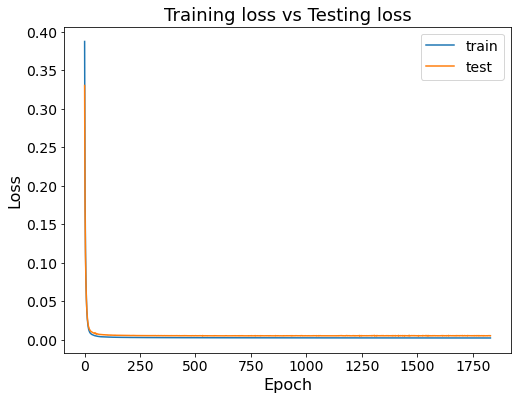

In [70]:
lr = 0.00001
EPOCHS = 8000 

lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-4, 
                                                          decay_steps=10000,
                                                          decay_rate=0.99)


model_cnn.compile(
#               optimizer=Adam(learning_rate=lr, decay=lr/EPOCHS), 
              optimizer=Adam(learning_rate=lr_schedule),
#               optimizer='adam',
              loss='mse',
              metrics=['mae'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=1000)
mc = ModelCheckpoint('saved_model/cnn_shift_best_model_12h_cp1.h5', monitor='val_mae', mode='min', verbose=2, save_best_only=True)


history = model_cnn.fit(train_X, train_y,
                    batch_size=512,
                    epochs=EPOCHS,
                    validation_data=(test_X, test_y),
                    verbose=2,
                    shuffle=True,
                       callbacks=[es, mc])

plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=14)
plt.title("Training loss vs Testing loss", fontsize=18)
# plt.savefig('graph/rnn_loss.png', dpi=300)
plt.show()

### Performance

In [71]:
from tensorflow.keras.models import load_model

saved_model = load_model('saved_model/cnn_shift_best_model_12h_cp1.h5')

In [72]:
yhat = saved_model.predict(test_X)
inv_yhat = scaler.inverse_transform(yhat)
inv_y = scaler.inverse_transform(test_y)

inv_yhat = pd.DataFrame(inv_yhat)
inv_y = pd.DataFrame(inv_y)
print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)

error = inv_yhat - inv_y
print(error.shape)

inv_y.shape, inv_yhat.shape (8744, 12) (8744, 12)
(8744, 12)


In [73]:
print('MAE = {}'.format(float("{:.3f}".format(mae(inv_yhat.iloc[:, :], inv_y.iloc[:, :])))))
print('RMSE = {}'.format(float("{:.3f}".format(sqrt(mse(inv_yhat.iloc[:, :], inv_y.iloc[:, :]))))))

MAE = 27.433
RMSE = 44.702
